In [2]:
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt

In [3]:
file = "1.wav"

In [4]:
signal, sample_rate = librosa.load(file, sr=22050)

Text(0.5, 1.0, 'Waveform')

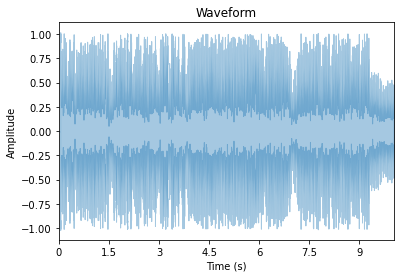

In [5]:
librosa.display.waveplot(signal, sample_rate, alpha=0.4)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

Text(0.5, 1.0, 'Power spectrum')

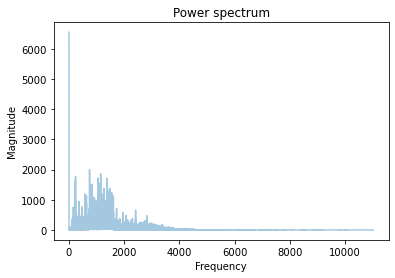

In [11]:
left_spectrum = spectrum[:int(len(spectrum)/2)]
left_f = f[:int(len(spectrum)/2)]
fft = np.fft.fft(signal)
spectrum = np.abs(fft)
f = np.linspace(0, sample_rate, len(spectrum))
plt.plot(left_f, left_spectrum, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")

In [12]:
hop_length = 512 
n_fft = 2048 
hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate
print("STFT hop length duration is: {}s".format(hop_length_duration))
print("STFT window duration is: {}s".format(n_fft_duration))

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


Text(0.5, 1.0, 'Spectrogram')

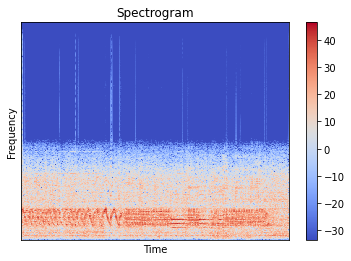

In [15]:
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
spectrogram = np.abs(stft)
log_spectrogram = librosa.amplitude_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")

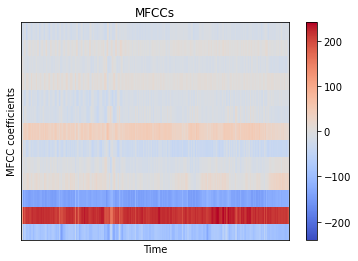

In [17]:
MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")
plt.show()

In [18]:
import json
import os
import math

In [295]:
dataset_path = "/Users/rahuladhupia/Desktop/project/data"
json_path = "data.json"
sample_rate = 22050
TRACK_DURATION = 10 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
num_segments=2

In [273]:
 data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }
    
 samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
 num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)   
    
 for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

        # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                
                # process all segments of audio file
                for d in range(num_segments):
                    
                    start = samples_per_segment * d
                    finish = start + samples_per_segment
                    
                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
                    mfcc = mfcc.T
                    
                    
                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))
 with open(json_path, "w") as fp:
    json.dump(data, fp, indent=4)


Processing: traffic
/Users/rahuladhupia/Desktop/project/data/traffic/16.wav, segment:1
/Users/rahuladhupia/Desktop/project/data/traffic/17.wav, segment:1
/Users/rahuladhupia/Desktop/project/data/traffic/15.wav, segment:1
/Users/rahuladhupia/Desktop/project/data/traffic/29.wav, segment:1
/Users/rahuladhupia/Desktop/project/data/traffic/100.wav, segment:1
/Users/rahuladhupia/Desktop/project/data/traffic/101.wav, segment:1
/Users/rahuladhupia/Desktop/project/data/traffic/28.wav, segment:1
/Users/rahuladhupia/Desktop/project/data/traffic/14.wav, segment:1
/Users/rahuladhupia/Desktop/project/data/traffic/10.wav, segment:1
/Users/rahuladhupia/Desktop/project/data/traffic/11.wav, segment:1
/Users/rahuladhupia/Desktop/project/data/traffic/39.wav, segment:1
/Users/rahuladhupia/Desktop/project/data/traffic/13.wav, segment:1
/Users/rahuladhupia/Desktop/project/data/traffic/12.wav, segment:1
/Users/rahuladhupia/Desktop/project/data/traffic/75.wav, segment:1
/Users/rahuladhupia/Desktop/project/dat

In [274]:
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf

In [275]:
data_path = "data.json"

In [298]:
with open(data_path, "r") as fp:
    data = json.load(fp)

    # convert lists to numpy arrays
X = np.array(data["mfcc"])
y = np.array(data["labels"])

print("Data succesfully loaded!")

Data succesfully loaded!


In [301]:
print(X.shape)

(108, 431, 13)


In [279]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [280]:
# build model
model = keras.Sequential([

        # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

        # 1st dense layer
    keras.layers.Dense(512, activation='relu'),

        # 2nd dense layer
    keras.layers.Dense(256, activation='relu'),

        # 3rd dense layer
    keras.layers.Dense(64, activation='relu'),

        # output layer
    keras.layers.Dense(2, activation='softmax')
])

In [281]:
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [282]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 5603)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 512)               2869248   
_________________________________________________________________
dense_53 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_54 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_55 (Dense)             (None, 2)                 130       
Total params: 3,017,154
Trainable params: 3,017,154
Non-trainable params: 0
_________________________________________________________________


In [283]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=50)

Epoch 1/50
3/3 [==============================] - 1s 133ms/step - loss: 28.5099 - accuracy: 0.5062 - val_loss: 18.6378 - val_accuracy: 0.6667
Epoch 2/50
3/3 [==============================] - 0s 45ms/step - loss: 10.9548 - accuracy: 0.7531 - val_loss: 7.7080 - val_accuracy: 0.7407
Epoch 3/50
3/3 [==============================] - 0s 41ms/step - loss: 5.0073 - accuracy: 0.7160 - val_loss: 2.6350 - val_accuracy: 0.8519
Epoch 4/50
3/3 [==============================] - 0s 36ms/step - loss: 1.9238 - accuracy: 0.9259 - val_loss: 3.0358 - val_accuracy: 0.8148
Epoch 5/50
3/3 [==============================] - 0s 43ms/step - loss: 1.3883 - accuracy: 0.9136 - val_loss: 2.8326 - val_accuracy: 0.8148
Epoch 6/50
3/3 [==============================] - 0s 37ms/step - loss: 0.7632 - accuracy: 0.8889 - val_loss: 3.0032 - val_accuracy: 0.8519
Epoch 7/50
3/3 [==============================] - 0s 47ms/step - loss: 0.3412 - accuracy: 0.9877 - val_loss: 4.3179 - val_accuracy: 0.7407
Epoch 8/50
3/3 [=======

In [297]:
A = X_test[0]
B = y_test[0]

# predict sample
A = A[np.newaxis, ...]

# perform prediction
prediction = model.predict(A)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Target: {}, Predicted label: {}".format(B, predicted_index))

Target: 0, Predicted label: [0]
